In [219]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

G = 6.6743e-11
Ms = 1.988416e30 #Mass of Sun kg
c = 299792458
L = G*Ms/c**2

### (a)

$P = K\rho^2$ <br>
$\frac{dm}{dr}= 4\pi r^2\rho$ <br>
Using definition of $P$,
$$\frac{d\nu}{dr} = 2\frac{m+4\pi r^3P}{r(r-2m)} = 2\frac{m+4\pi K\rho^2r^3}{r(r-2m)}$$
$\frac{dP}{dr} = -\frac{m+4\pi r^3P}{r(r-2m)}(\rho+P) = -\frac{1}{2}(\rho+P)\nu'$ <br>
$\frac{dp}{d\rho}\frac{d\rho}{dr} = -\frac{m+4\pi r^3P}{r(r-2m)}(\rho+P) \to 2K\rho\frac{d\rho}{dr} = -\frac{m+4\pi K\rho^2 r^3}{r(r-2m)}(\rho+K\rho^2)$. Then,

$$\frac{d\rho}{dr} = -\frac{m+4\pi K\rho^2 r^3}{r(r-2m)}\frac{1+K\rho}{2K} = -\frac{1}{2}\frac{1+K\rho}{2K}\nu'$$


In [174]:
def TOV(r, y, K=100):
    m, ν, ρ, mP = y
    dm = 4*np.pi*r**2*ρ
    dν = 2*(m+4*np.pi*K*(ρ**2)*(r**3))/(r*(r-2*m)) if r > 0 else 0
    dρ = -(1+K*ρ)/(4*K)*dν
    dmP = 4*np.pi/np.sqrt(1-2*m/r)*(r**2)*ρ if r > 0 else 0
    return [dm, dν, dρ, dmP]

def stop(r, y, K=100): #Stop condition: do not let ρ be negative
    ρ = y[2]
    return 0 if ρ < 1e-10 else 1
stop.terminal = True

#Solves the white dwarf system with solve_ivp for given params.
def solve_TOV(ρc,max_step=0.1,K=100):
    y0 = (0,0,ρc,0)
    solution = solve_ivp(TOV, [0, 20], y0, events=stop, max_step=max_step, args=(K,))
    return solution

def obtain_NS_params(ρc,max_step=0.1,K=100): #Function that solves TOV for given central densities
    M = 0*ρc; R = 0*ρc; MP = 0*ρc
    for i in range(len(ρc)):
        solution = solve_TOV(ρc[i],max_step=max_step,K=K)
        M[i] = solution.y[0][-1]
        MP[i] = solution.y[3][-1]
        R[i] = solution.t[-1]
    return M,MP,R

Text(0.5, 1.0, 'Neutron Star Mass vs Radius')

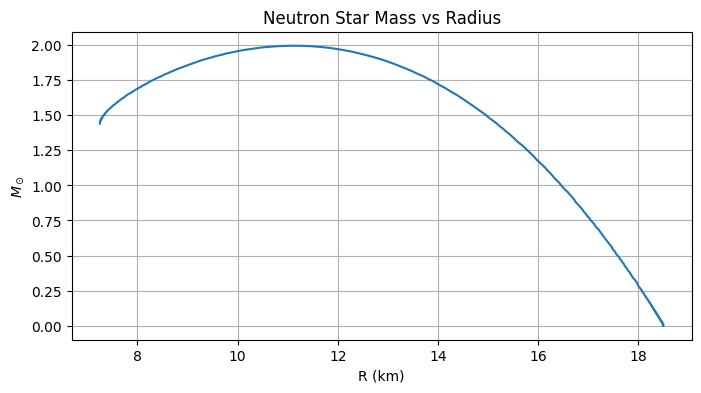

In [214]:
ρc = np.logspace(-7,-1,500)
_M,_MP,_R = obtain_NS_params(ρc,max_step=0.01)
plt.figure(figsize=(8,4))
plt.plot(_R*L/1000,_M); plt.grid()
plt.xlabel('R (km)'); plt.ylabel(r'$M_\odot$')
plt.title('Neutron Star Mass vs Radius')

### (b)

Text(0.5, 1.0, 'Fractional Binding Energy vs Radius')

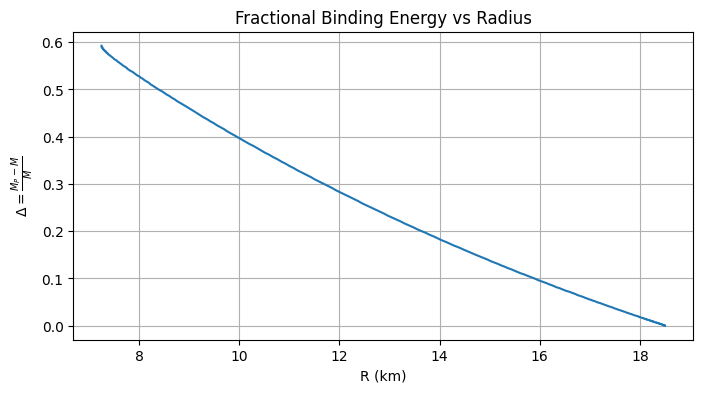

In [215]:
Δ = (_MP-_M)/_M
plt.figure(figsize=(8,4))
plt.plot(_R*L/1000,Δ); plt.grid()
plt.xlabel('R (km)'); plt.ylabel(r'$\Delta = \frac{M_P-M}{M}$')
plt.title('Fractional Binding Energy vs Radius')

### (c)

In [ ]:
# def calc_arbitrary_stencils(s, d):      #Function to calculate arbitrary finite difference stencil for dth derivative of stencil s
#     N = len(s)                          #Length of stencil s
#     A = s**np.arange(N)[:,np.newaxis]   #Matrix of powers of s to solve
#     b = np.zeros((N,1))                 #b of linear system Ax=b
#     b[d] = factorial(d)                 #b_d = d!
#     a = np.linalg.solve(A,b).ravel()    #Solve linear system for coefficents a
#     return a

# def numerical_derivative_irregular(fx, x): #Take irregular derivative of irregularly spaced f(x)
#     dfx = 0*fx
#     for i in range(1,len(x)-1):
#         a = calc_arbitrary_stencils([x[i-1]-x[i],0,x[i+1]-x[i]],1) #Calculate stencils for first derivative
#         dfx[i] = np.sum(a*fx[i-1:i+2]) #Apply stencils to array to find irregular derivative
#     a = calc_arbitrary_stencils([0,x[1]-x[0],x[2]-x[0]],1) #Calculate backward stencil for first point
#     dfx[0] = np.sum(a*fx[0:3]) #Apply backward stencil for first point
#     a = calc_arbitrary_stencils([x[-3]-x[-1],x[-2]-x[-1],0],1) #Calculate forward stencil for last point
#     dfx[-1] = np.sum(a*fx[-3:]) #Apply forward stencil for last point
#     return dfx

Mmax = 1.9951601132859622


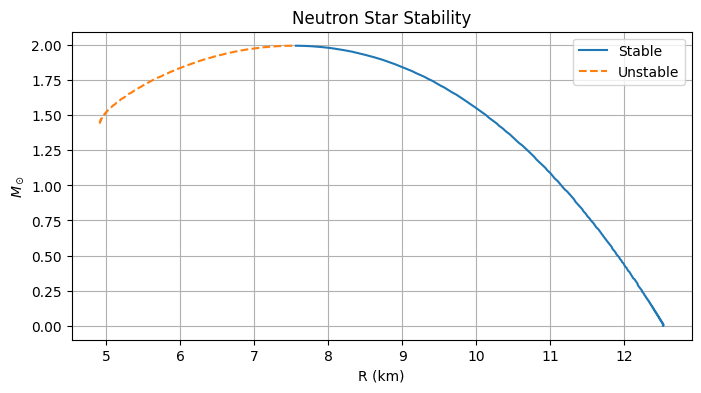

In [217]:
dM = np.convolve(_M,[-0.5,0,0.5],'same')
dM[0] = -(-1.5*_M[0]+2*_M[1]-0.5*_M[2])  #For some reason, it keeps being positive. Assuming it is negative.
dM[-1] = -(1.5*_M[-1]-2*_M[-2]+0.5*_M[-3])  #It is positive, unexpectedly. Taking as negative.
dM = -dM #Reversely arranged
#Endpoints behave against function behavior due to calculation errors.


#Since M in array arranged with the same order of ρc
#And ρc is an increasing array, dρc > 0 always.
#The only important factor is sign of the derivative
#So we can look sign of dM instead of derivative.
#Derivative can be calculated with numerical_derivative_irregular function
#But as for me, it is not required since the important factor is the sign.

stableM = _M[dM > 0]
stableR = _R[dM > 0]
unstableM = _M[dM < 0]
unstableR = _R[dM < 0]
plt.figure(figsize=(8,4))
plt.plot(stableR,stableM)
plt.plot(unstableR,unstableM,'--')
plt.legend(['Stable','Unstable']); plt.grid()
plt.xlabel('R (km)'); plt.ylabel(r'$M_\odot$')
plt.title('Neutron Star Stability')

print("Mmax = " + str(np.max(_M)))

### (d)

In [207]:
def obtain_max_mass(ρc,K,max_step=0.1): #Function that solves TOV for maximized mass
    Mmax = 0
    for i in range(len(ρc)):
        solution = solve_TOV(ρc[i],max_step=max_step,K=K)
        M_ = solution.y[0][-1]
        if M_ > Mmax:
            Mmax = M_
    return Mmax

Maximum Allowed K = 114


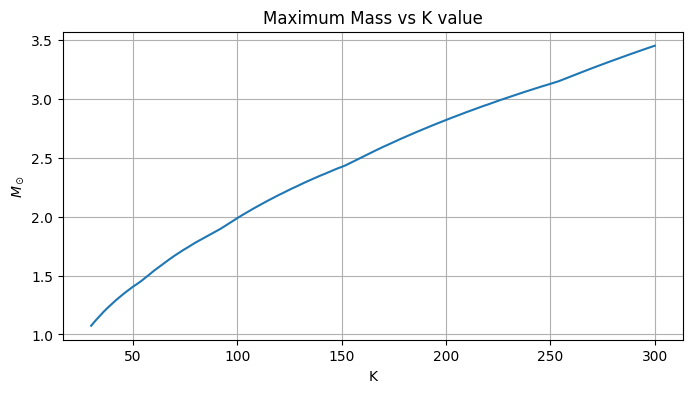

In [218]:
K = np.arange(30,301,2)
_Mmax = np.zeros(np.shape(K))
_ρc = np.logspace(-4,-2,10)
for i in range(len(K)):
    _Mmax[i] = obtain_max_mass(_ρc,K[i])
    
plt.figure(figsize=(8,4))
plt.plot(K,_Mmax); plt.grid()
plt.xlabel('K'); plt.ylabel(r'$M_\odot$')
plt.title('Maximum Mass vs K value')
print("Maximum Allowed K = " + str(K[_Mmax == np.max(_Mmax * (_Mmax < 2.14))][0]))

### (e)

$\frac{d\nu}{dr} = \frac{2M}{r(r-2M)}=\frac{1}{r-2M}-\frac{1}{r}$ <br>
$\int_R^{r}d\nu  =\int_R^{r}\frac{dr'}{r'-2M}-\int_R^{r}\frac{dr'}{r'}$ <br>
$\nu(r)-\nu(R)  = ln(r-2M)-ln(R-2M)-(ln(r)-ln(R))$ <br>
$$\nu(r > R)  = ln(1-\frac{2M}{r})-ln(1-\frac{2M}{R}) + \nu(R)$$